In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1

# Define channel gain and Rayleigh fading parameters
path_loss_exponent = 2.0
noise_power = 0.01

# SNR with UAV-RIS (Unoptimized)
snr_uav_unoptimized = 0

Optimal Energy Group Indices: [ 14 207 218 223 253 117 159  65 277 114  16 279   3  73 158  25 110 185
 108  98 163 248  30 142 112 254 288 264 184 118 231 174  50  79  95 165
 137 290  18 247  21 215 239 128  12 152 245 283  93 278 175  32 269  58
 191  84  13 119 273  87 200 183 240 156  66 189  53 195 135 288 100 139
 107 287 154 181 132  39 250 150 258  44   4  86 234 147 115  90 121 188
  78 194 227 241 266 161   6 203  57 146 220 217   1  96 282  35 202 255
 237  27 276 295  52 204  21  48 235 252  72 229  71 226 180 138 104 168
  94 143 140 274 190 149  83  17  22 209  46 246  26 213  60  75  40 260
 296 201 274 272 131  28]
Optimal Signal Group Indices: [0, 2, 5, 7, 8, 9, 10, 11, 15, 19, 20, 23, 24, 29, 31, 33, 34, 36, 37, 38, 41, 42, 43, 45, 47, 49, 51, 54, 55, 56, 59, 61, 62, 63, 64, 67, 68, 69, 70, 74, 76, 77, 80, 81, 82, 85, 88, 89, 91, 92, 97, 99, 101, 102, 103, 105, 106, 109, 111, 113, 116, 120, 122, 123, 124, 125, 126, 127, 129, 130, 133, 134, 136, 141, 144, 145, 148, 15

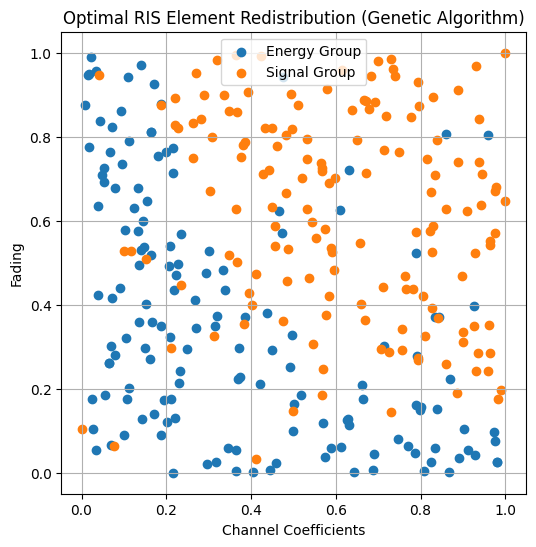

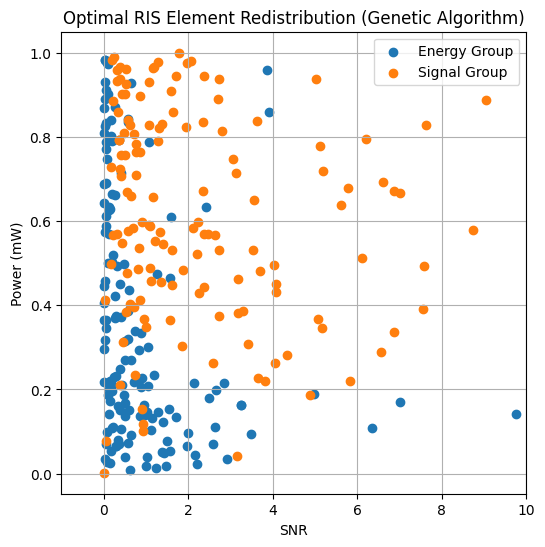

In [13]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and fading
channel_coefficients = np.random.rand(num_elements)
fading = np.random.rand(num_elements)
# rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)


def calculate_elements(channel_coefficients, fading):
    snr_values = (
        channel_coefficients
        * fading
        / (channel_coefficients * (1 - fading) + noise_power)
    )
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))


elements = calculate_elements(channel_coefficients, fading)


def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))

    # Generate AWGN noise based on noise power
    noise_samples = np.random.normal(scale=np.sqrt(noise_power))

    # Add noise to the received signal
    signal_with_noise = signal_power + noise_samples

    # Compute the SNR considering noise
    snr = signal_with_noise / (energy_power + noise_power)
    power = energy_power + signal_with_noise
    return snr, power


def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading)
    energy_indices = sorted_indices[: num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2 :]
    return energy_indices, signal_indices


def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(
        channel_coefficients[energy_indices], fading[energy_indices]
    )
    return 1 / (snr * power)


def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(
        channel_coefficients, fading
    )

    # Initialize population
    population = [energy_indices] * population_size

    for i in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate(
                    (parent1[:crossover_point], parent2[crossover_point:])
                )
                child2 = np.concatenate(
                    (parent2[:crossover_point], parent1[crossover_point:])
                )
            else:
                child1 = parent1
                child2 = parent2

            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])

        population = new_population

        best_individual = min(
            population,
            key=lambda ind: evaluate_fitness(
                ind, list(set(range(num_elements)) - set(ind))
            ),
        )

        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(
            channel_coefficients[best_energy_indices], fading[best_energy_indices]
        )

        if i == 0:
            global snr_uav_unoptimized
            snr_uav_unoptimized = best_snr

    return best_energy_indices, best_signal_indices, best_snr, best_power


# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance**path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance**path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (
    (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100
)

# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS (Unoptimized):", snr_uav_unoptimized, "dB")
print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
print("Optimal Power (Optimized):", best_power, "mW")
print("Improvement Percentage:", improvement_percentage, "%")


# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(
    channel_coefficients[best_energy_indices],
    fading[best_energy_indices],
    label="Energy Group",
)
plt.scatter(
    channel_coefficients[best_signal_indices],
    fading[best_signal_indices],
    label="Signal Group",
)
plt.xlabel("Channel Coefficients")
plt.ylabel("Fading")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution based on SNR and Power
plt.figure(figsize=(6, 6))
plt.scatter(
    elements[best_energy_indices, 0],
    elements[best_energy_indices, 1],
    label="Energy Group",
)
plt.scatter(
    elements[best_signal_indices, 0],
    elements[best_signal_indices, 1],
    label="Signal Group",
)
plt.xlabel("SNR")
# x from 0 to 10
plt.xlim(-1, 10)
plt.ylabel("Power (mW)")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)
plt.show()